# set up env

In [ ]:
# upload zip of the dataset 
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

!unzip trainingDataset.zip
!unzip testDataset.zip

Saving testDataset.zip to testDataset.zip
Saving trainingDataset.zip to trainingDataset.zip
User uploaded file "testDataset.zip" with length 2806674 bytes
User uploaded file "trainingDataset.zip" with length 22319895 bytes
Archive:  trainingDataset.zip
   creating: trainingDataset/annots/
  inflating: trainingDataset/annots/1.xml  
  inflating: trainingDataset/annots/10.xml  
  inflating: trainingDataset/annots/100.xml  
  inflating: trainingDataset/annots/101.xml  
  inflating: trainingDataset/annots/102.xml  
  inflating: trainingDataset/annots/103.xml  
  inflating: trainingDataset/annots/104.xml  
  inflating: trainingDataset/annots/105.xml  
  inflating: trainingDataset/annots/106.xml  
  inflating: trainingDataset/annots/107.xml  
  inflating: trainingDataset/annots/108.xml  
  inflating: trainingDataset/annots/109.xml  
  inflating: trainingDataset/annots/11.xml  
  inflating: trainingDataset/annots/110.xml  
  inflating: trainingDataset/annots/111.xml  
  inflating: trainingDat

In [ ]:
!pip install keras==2.1.6
!pip install tensorflow==1.15.0

     |████████████████████████████████| 348kB 7.2MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 412.3MB 22kB/s 
     |████████████████████████████████| 512kB 46.0MB/s 
     |████████████████████████████████| 3.8MB 47.5MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=d5871103b1ee2decae80ad8a503fd5bf319c3f51315bc675d35756297f257a9b
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: gast 0.3.3
    Uninsta

In [ ]:
%%shell
# clone Mask_RCNN repo and install packages
git clone https://github.com/matterport/Mask_RCNN
cd Mask_RCNN
python setup.py install

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 35.97 MiB/s, done.
Resolving deltas: 100% (561/561), done.
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/utils.py -> build/li

In [ ]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("./Mask_RCNN/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


... done downloading pretrained model!


# train amoeba dataset

In [ ]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN

class AmoebaDataset(Dataset):
	def load_dataset(self, dataset_dir, is_train=True):
		self.add_class("dataset", 1, "amoeba")
		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annots/'
		for filename in listdir(images_dir):
			image_id = filename[:-4]
			if is_train and int(image_id) >= 170:
				continue
			if not is_train and int(image_id) < 170:
				continue
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

	# extract bounding boxes from an annotation file
	def extract_boxes(self, filename):
		tree = ElementTree.parse(filename)
		root = tree.getroot()
		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height

	# load the masks for an image
	def load_mask(self, image_id):
		info = self.image_info[image_id]
		path = info['annotation']
		boxes, w, h = self.extract_boxes(path)
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('amoeba'))
		return masks, asarray(class_ids, dtype='int32')

	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']

class AmoebaConfig(Config):
	NAME = "amoeba_cfg"
	NUM_CLASSES = 1 + 1
	STEPS_PER_EPOCH = 131
	DETECTION_NMS_THRESHOLD = 0.5

# prepare train set
train_set = AmoebaDataset()
train_set.load_dataset('trainingDataset', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# prepare val set
val_set = AmoebaDataset()
val_set.load_dataset('trainingDataset', is_train=False)
val_set.prepare()
print('Val: %d' % len(val_set.image_ids))
# prepare config
config = AmoebaConfig()
config.display()


Train: 169
Val: 27

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.5
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14


In [ ]:
# run tensorboard
import keras
import os
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
print(run_logdir)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

./my_logs/run_2021_02_06-17_46_41


In [ ]:
# train the model
model = MaskRCNN(mode='training', model_dir='./', config=config)
model.load_weights('Mask_RCNN/mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
model.train(train_set, val_set, learning_rate=0.002, epochs=20, layers='heads', custom_callbacks=[tensorboard_cb])






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead







Starting at epoch 0. LR=0.002

Checkpoint Path: ./amoeba_cfg20210206T1746/mask_rcnn_amoeba_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/20
130/131 [============================>.] - ETA: 1s - loss: 0.8605 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.1420 - mrcnn_class_loss: 0.0674 - mrcnn_bbox_loss: 0.3385 - mrcnn_mask_loss: 0.3013

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2348: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


131/131 [==============================] - 219s 2s/step - loss: 0.8560 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.1412 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.3366 - mrcnn_mask_loss: 0.3000 - val_loss: 0.7655 - val_rpn_class_loss: 0.0047 - val_rpn_bbox_loss: 0.1649 - val_mrcnn_class_loss: 0.0502 - val_mrcnn_bbox_loss: 0.2535 - val_mrcnn_mask_loss: 0.2922

Epoch 2/20
131/131 [==============================] - 174s 1s/step - loss: 0.4925 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1227 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.2067 - val_loss: 0.6484 - val_rpn_class_loss: 0.0054 - val_rpn_bbox_loss: 0.1564 - val_mrcnn_class_loss: 0.0415 - val_mrcnn_bbox_loss: 0.1717 - val_mrcnn_mask_loss: 0.2734
Epoch 3/20
131/131 [==============================] - 173s 1s/step - loss: 0.4399 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1065 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.1005 - mrcnn_mask_loss: 0.1982 - val_loss: 0.6353 - val_rpn_class_loss: 0.002

# evaluate amoeba dataset
 


## mAP

In [ ]:
# evaluate the mask rcnn model on the amoeba dataset
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

class PredictionConfig(Config):
	NAME = "amoeba_cfg"
	NUM_CLASSES = 1 + 1
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		scaled_image = mold_image(image, cfg)
		sample = expand_dims(scaled_image, 0)
		yhat = model.detect(sample, verbose=0)
		r = yhat[0]
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		APs.append(AP)
	mAP = mean(APs)
	return mAP

# load the train dataset
train_set = AmoebaDataset()
train_set.load_dataset('trainingDataset', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# load the val dataset
val_set = AmoebaDataset()
val_set.load_dataset('trainingDataset', is_train=False)
val_set.prepare()
print('Val: %d' % len(val_set.image_ids))
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model.load_weights('amoeba_cfg20210206T1746/mask_rcnn_amoeba_cfg_0007.h5', by_name=True)  #the directory can be changed
# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
val_mAP = evaluate_model(val_set, model, cfg)
print("Val mAP: %.3f" % val_mAP)

Train: 169
Val: 27
Train mAP: 0.914
Val mAP: 0.865


In [ ]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

class PredictionConfig(Config):
	NAME = "amoeba_cfg"
	NUM_CLASSES = 1 + 1
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		scaled_image = mold_image(image, cfg)
		sample = expand_dims(scaled_image, 0)
		yhat = model.detect(sample, verbose=0)
		r = yhat[0]
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		APs.append(AP)
	# calculate the mean AP across all images
	mAP = mean(APs)
	return mAP

# load the test dataset
test_set = AmoebaDataset()
test_set.load_dataset('testDataset')
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model.load_weights('amoeba_cfg20210206T1746/mask_rcnn_amoeba_cfg_0007.h5', by_name=True) #the directory can be changed
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

Test: 20
Test mAP: 0.893


# test dataset pred and inference



## drop predict

In [ ]:
!rm -rf c1 predImagesC1

In [ ]:
# upload zip of predDataset 
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

!unzip c1.zip

Saving c1.zip to c1.zip
User uploaded file "c1.zip" with length 2137221 bytes
Archive:  c1.zip
  inflating: c1/1.jpg                
  inflating: c1/10.jpg               
  inflating: c1/11.jpg               
  inflating: c1/12.jpg               
  inflating: c1/13.jpg               
  inflating: c1/14.jpg               
  inflating: c1/16.jpg               
  inflating: c1/17.jpg               
  inflating: c1/18.jpg               
  inflating: c1/19.jpg               
  inflating: c1/2.jpg                
  inflating: c1/20.jpg               
  inflating: c1/21.jpg               
  inflating: c1/22.jpg               
  inflating: c1/23.jpg               
  inflating: c1/24.jpg               
  inflating: c1/25.jpg               
  inflating: c1/26.jpg               
  inflating: c1/27.jpg               
  inflating: c1/28.jpg               
  inflating: c1/29.jpg               
  inflating: c1/3.jpg                
  inflating: c1/30.jpg               
  inflating: c1/31.jpg         

In [ ]:
# evaluate the mask rcnn model on the amoeba dataset
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

# define the prediction configuration
class PredictionConfig(Config):
	NAME = "amoeba_cfg"
	NUM_CLASSES = 1 + 1
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

cfg = PredictionConfig()
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
model_path = 'amoeba_cfg20210206T1746/mask_rcnn_amoeba_cfg_0007.h5'
model.load_weights(model_path, by_name=True)

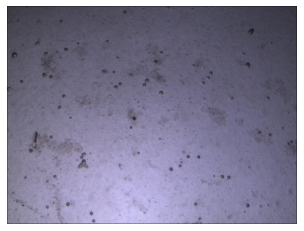

The number of amoeba is  0
0


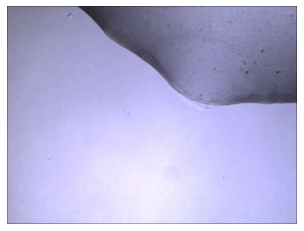

The number of amoeba is  0
0


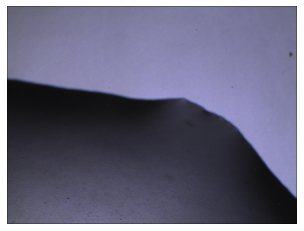

The number of amoeba is  0
0


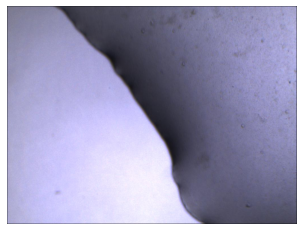

The number of amoeba is  0
0


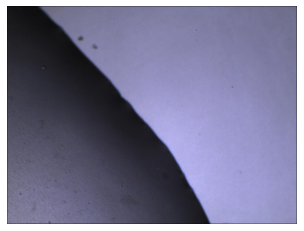

The number of amoeba is  0
0


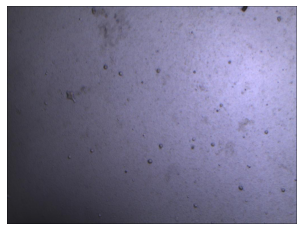

The number of amoeba is  0
0


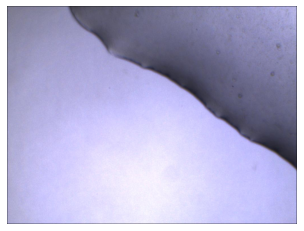

The number of amoeba is  0
0


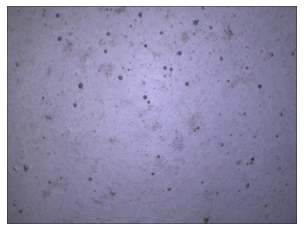

The number of amoeba is  0
0


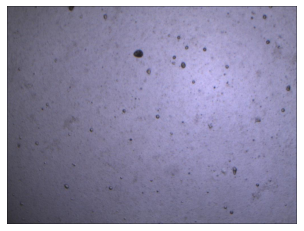

The number of amoeba is  0
0


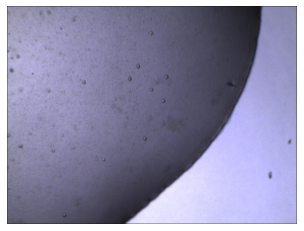

The number of amoeba is  0
0


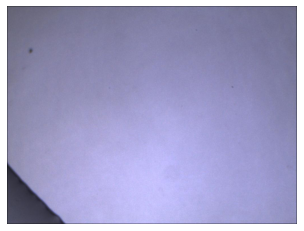

The number of amoeba is  0
0


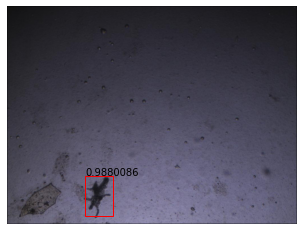

The number of amoeba is  1
1


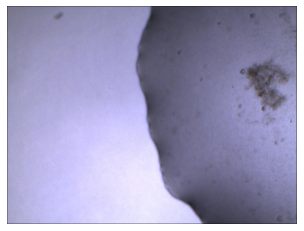

The number of amoeba is  0
1


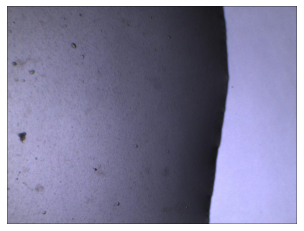

The number of amoeba is  0
1


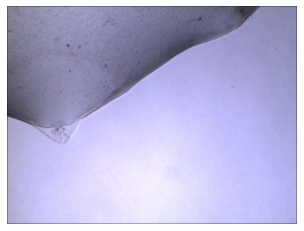

The number of amoeba is  0
1


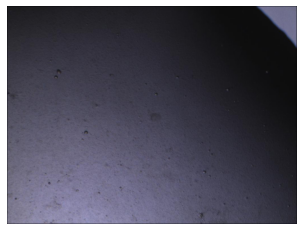

The number of amoeba is  0
1


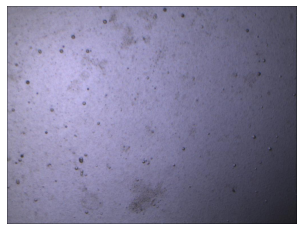

The number of amoeba is  0
1


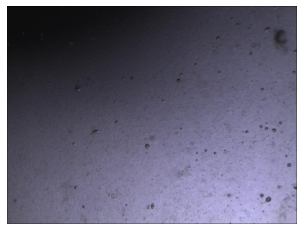

The number of amoeba is  0
1


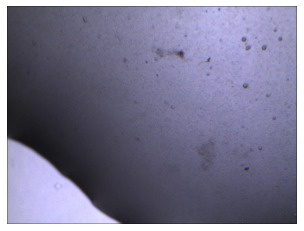

The number of amoeba is  0
1


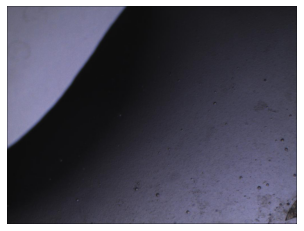

The number of amoeba is  0
1


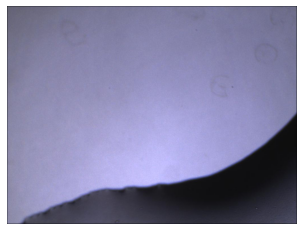

The number of amoeba is  0
1


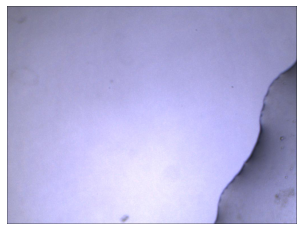

The number of amoeba is  0
1


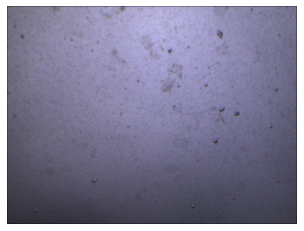

The number of amoeba is  0
1


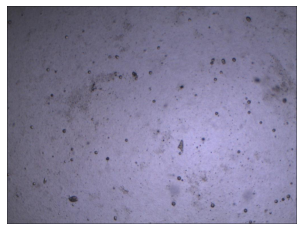

The number of amoeba is  0
1


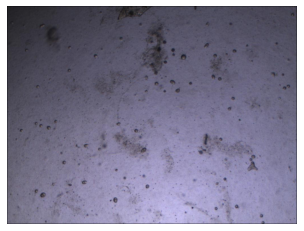

The number of amoeba is  0
1


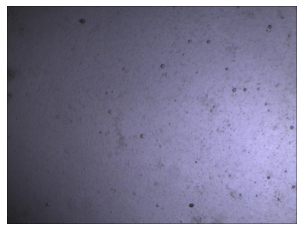

The number of amoeba is  0
1


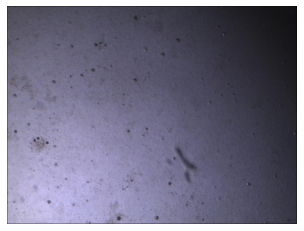

The number of amoeba is  0
1


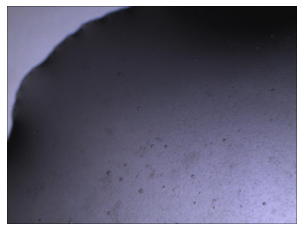

The number of amoeba is  0
1


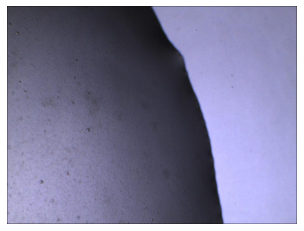

The number of amoeba is  0
1


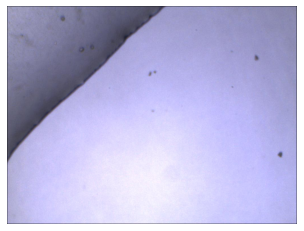

The number of amoeba is  0
1


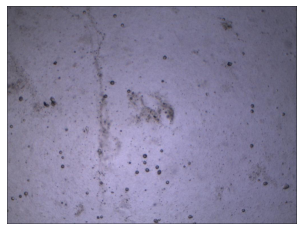

The number of amoeba is  0
1


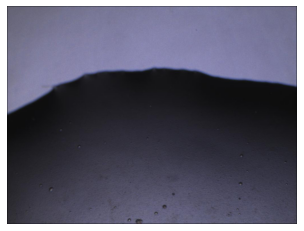

The number of amoeba is  0
1


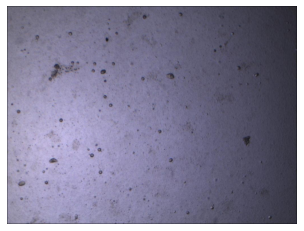

The number of amoeba is  0
1


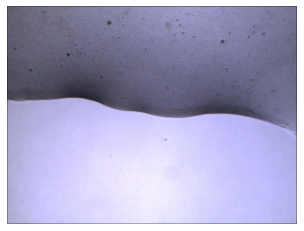

The number of amoeba is  0
1


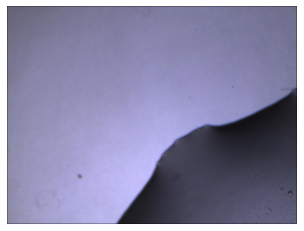

The number of amoeba is  0
1


In [ ]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle

def plot_predicted(image, model, cfg):
  image = np.asanyarray(image)
  scaled_image = mold_image(image, cfg)
  sample = expand_dims(image, 0)
  yhat = model.detect(sample, verbose=0)[0]
  pyplot.imshow(image)
  ax = pyplot.gca()
  pyplot.axis("off")
  for box in yhat['rois']:
    y1, x1, y2, x2 = box
    width, height = x2 - x1, y2 - y1
    rect = Rectangle((x1, y1), width, height, fill=False, color='red')
    ax.add_patch(rect)
  pyplot.savefig("image.jpg")
  pyplot.show()
  
    
def count1_amoeba(image, model, cfg):
  image = np.asanyarray(image)
  scaled_image = mold_image(image, cfg)
  sample = expand_dims(image, 0)
  yhat = model.detect(sample, verbose=0)[0]
  count=0
  for box,confidence in zip(yhat['rois'],yhat['scores']):
    if confidence >=0.96:
      count = count +1
  print("The number of amoeba is ", count)
  return count

def save_predicted(image, model, cfg, filename):
  image = np.asanyarray(image)
  scaled_image = mold_image(image, cfg)
  sample = expand_dims(image, 0)
  yhat = model.detect(sample, verbose=0)[0]
  pyplot.imshow(image)
  ax = pyplot.gca()
  pyplot.axis("off")
  for box,confidence in zip(yhat['rois'],yhat['scores']):
    if confidence >= 0.96:
      y1, x1, y2, x2 = box
      width, height = x2 - x1, y2 - y1
      rect = Rectangle((x1, y1), width, height, fill=False, color='red')
      pyplot.text(x1,y1,confidence)
      ax.add_patch(rect)

  filename ="predImagesC1/" + filename
  pyplot.savefig(filename,bbox_inches='tight',pad_inches=0.0)
  pyplot.show()

from PIL import Image
if not os.path.exists("predImagesC1"):
  os.mkdir("predImagesC1")

images_dir = "c1"
t=0
for img in listdir(images_dir):
  img_path = images_dir + "/" + img
  image = Image.open(img_path)
  image = np.asanyarray(image)
  #plot_predicted(image, model, cfg)
  save_predicted(image, model, cfg, img)
  t=t + count1_amoeba(image,model,cfg)
  print(t)

In [ ]:
!zip -r predImagesC1.zip predImagesC1
from google.colab import files
files.download("predImagesC1.zip")

  adding: predImagesC1/ (stored 0%)
  adding: predImagesC1/14.jpg (deflated 1%)
  adding: predImagesC1/34.jpg (deflated 1%)
  adding: predImagesC1/3.jpg (deflated 2%)
  adding: predImagesC1/24.jpg (deflated 1%)
  adding: predImagesC1/5.jpg (deflated 1%)
  adding: predImagesC1/25.jpg (deflated 1%)
  adding: predImagesC1/33.jpg (deflated 1%)
  adding: predImagesC1/27.jpg (deflated 1%)
  adding: predImagesC1/26.jpg (deflated 1%)
  adding: predImagesC1/29.jpg (deflated 1%)
  adding: predImagesC1/4.jpg (deflated 2%)
  adding: predImagesC1/7.jpg (deflated 1%)
  adding: predImagesC1/23.jpg (deflated 1%)
  adding: predImagesC1/18.jpg (deflated 1%)
  adding: predImagesC1/36.jpg (deflated 1%)
  adding: predImagesC1/6.jpg (deflated 1%)
  adding: predImagesC1/28.jpg (deflated 1%)
  adding: predImagesC1/12.jpg (deflated 1%)
  adding: predImagesC1/32.jpg (deflated 1%)
  adding: predImagesC1/8.jpg (deflated 1%)
  adding: predImagesC1/9.jpg (deflated 1%)
  adding: predImagesC1/10.jpg (deflated 1%)
  a

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## testdataset

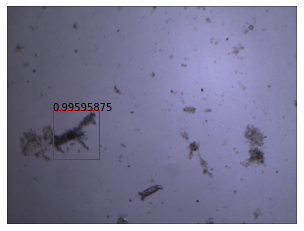

The number of amoeba is  1
1


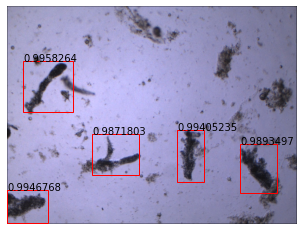

The number of amoeba is  5
6


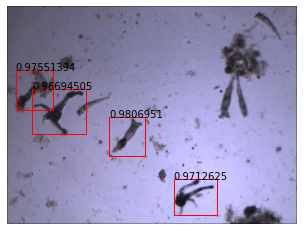

The number of amoeba is  4
10


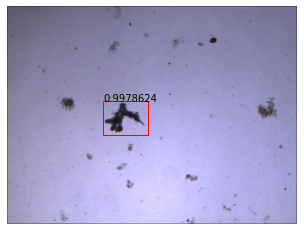

The number of amoeba is  1
11


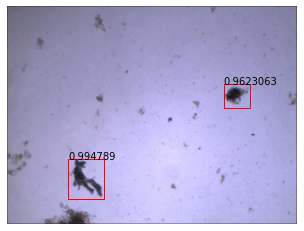

The number of amoeba is  2
13


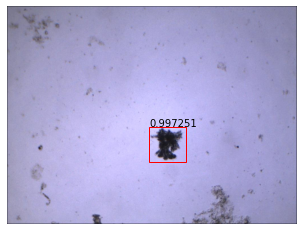

The number of amoeba is  1
14


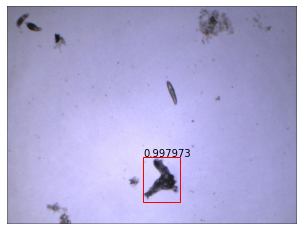

The number of amoeba is  1
15


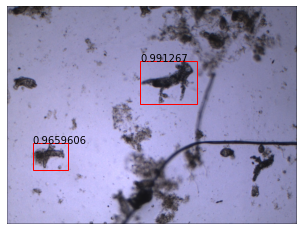

The number of amoeba is  2
17


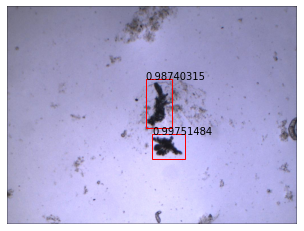

The number of amoeba is  2
19


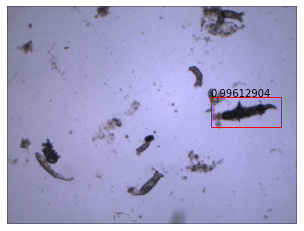

The number of amoeba is  1
20


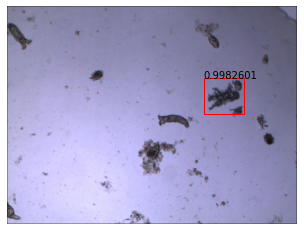

The number of amoeba is  1
21


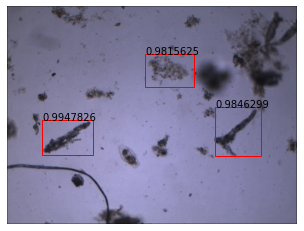

The number of amoeba is  3
24


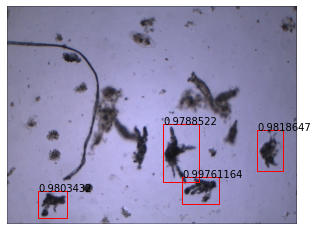

The number of amoeba is  4
28


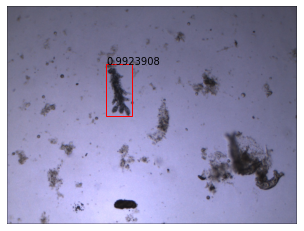

The number of amoeba is  1
29


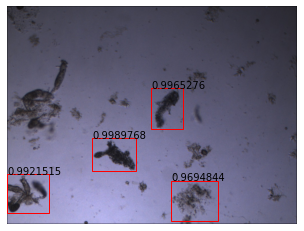

The number of amoeba is  4
33


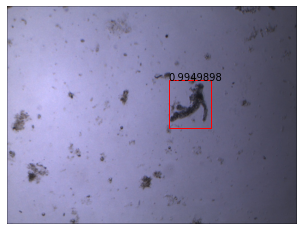

The number of amoeba is  1
34


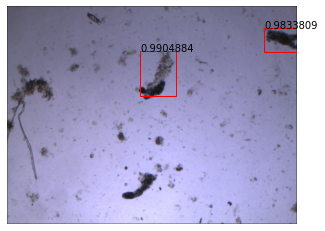

The number of amoeba is  2
36


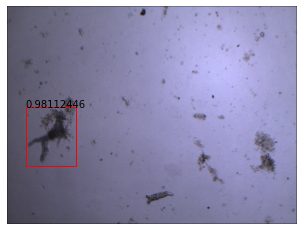

The number of amoeba is  1
37


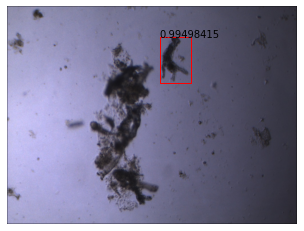

The number of amoeba is  1
38


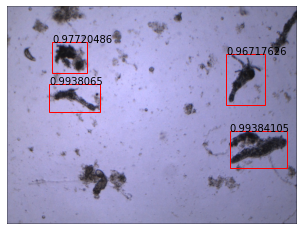

The number of amoeba is  4
42


In [ ]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle

def plot_predicted(image, model, cfg):
  image = np.asanyarray(image)
  scaled_image = mold_image(image, cfg)
  sample = expand_dims(image, 0)
  yhat = model.detect(sample, verbose=0)[0]
  pyplot.imshow(image)
  #pyplot.title('Predicted')
  ax = pyplot.gca()
  pyplot.axis("off")
  for box in yhat['rois']:
    y1, x1, y2, x2 = box
    width, height = x2 - x1, y2 - y1
    rect = Rectangle((x1, y1), width, height, fill=False, color='red')
    ax.add_patch(rect)
  pyplot.savefig("image.jpg")
  pyplot.show()
  
    
def count1_amoeba(image, model, cfg):
  image = np.asanyarray(image)
  scaled_image = mold_image(image, cfg)
  sample = expand_dims(image, 0)
  yhat = model.detect(sample, verbose=0)[0]
  count=0
  for box,confidence in zip(yhat['rois'],yhat['scores']):
    if confidence >=0.96:
      count = count +1
  print("The number of amoeba is ", count)
  return count

def save_predicted(image, model, cfg, filename):
  image = np.asanyarray(image)
  scaled_image = mold_image(image, cfg)
  sample = expand_dims(image, 0)
  yhat = model.detect(sample, verbose=0)[0]
  pyplot.imshow(image)
  #pyplot.title('Predicted')
  ax = pyplot.gca()
  pyplot.axis("off")
  for box,confidence in zip(yhat['rois'],yhat['scores']):
    if confidence >=0.96:
      y1, x1, y2, x2 = box
      width, height = x2 - x1, y2 - y1
      rect = Rectangle((x1, y1), width, height, fill=False, color='red')
      pyplot.text(x1,y1,confidence)
      ax.add_patch(rect)

  filename ="testDataset-pred/" + filename
  pyplot.savefig(filename,bbox_inches='tight',pad_inches=0.0)
  pyplot.show()

from PIL import Image
if not os.path.exists("testDataset-pred"):
  os.mkdir("testDataset-pred")

images_dir = "testDataset/images"
t=0
for img in listdir(images_dir):
  img_path = images_dir + "/" + img
  image = Image.open(img_path)
  image = np.asanyarray(image)
  #plot_predicted(image, model, cfg)
  save_predicted(image, model, cfg, img)
  t=t + count1_amoeba(image,model,cfg)
  print(t)

In [ ]:
!zip -r testDataset-pred.zip testDataset-pred
from google.colab import files
files.download("testDataset-pred.zip")

  adding: testDataset-pred/ (stored 0%)
  adding: testDataset-pred/14.jpg (deflated 1%)
  adding: testDataset-pred/3.jpg (deflated 1%)
  adding: testDataset-pred/5.jpg (deflated 1%)
  adding: testDataset-pred/25.jpg (deflated 1%)
  adding: testDataset-pred/27.jpg (deflated 1%)
  adding: testDataset-pred/26.jpg (deflated 1%)
  adding: testDataset-pred/29.jpg (deflated 1%)
  adding: testDataset-pred/7.jpg (deflated 1%)
  adding: testDataset-pred/23.jpg (deflated 1%)
  adding: testDataset-pred/8.jpg (deflated 1%)
  adding: testDataset-pred/9.jpg (deflated 1%)
  adding: testDataset-pred/13.jpg (deflated 1%)
  adding: testDataset-pred/22.jpg (deflated 1%)
  adding: testDataset-pred/16.jpg (deflated 1%)
  adding: testDataset-pred/11.jpg (deflated 1%)
  adding: testDataset-pred/20.jpg (deflated 1%)
  adding: testDataset-pred/2.jpg (deflated 1%)
  adding: testDataset-pred/15.jpg (deflated 1%)
  adding: testDataset-pred/19.jpg (deflated 1%)
  adding: testDataset-pred/1.jpg (deflated 1%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## prediction time

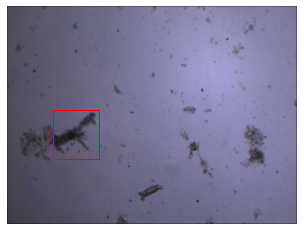

prediction time is 0.6956586837768555s


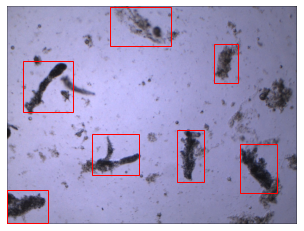

prediction time is 1.2905807495117188s


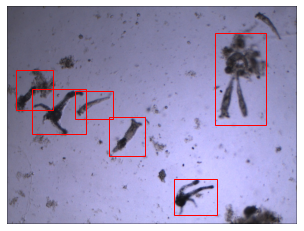

prediction time is 0.6494629383087158s


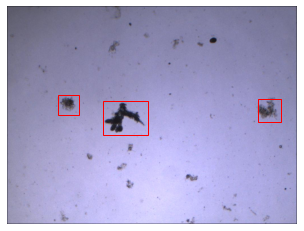

prediction time is 0.597304105758667s


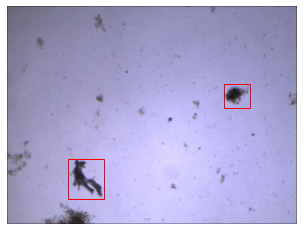

prediction time is 0.6016719341278076s


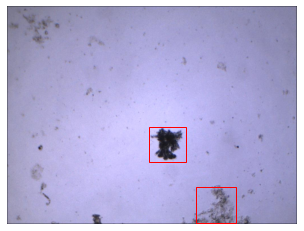

prediction time is 0.5961184501647949s


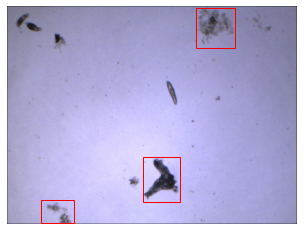

prediction time is 0.6010229587554932s


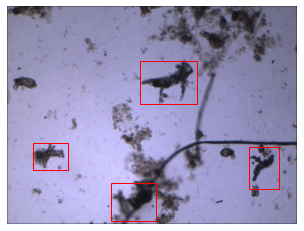

prediction time is 0.6139333248138428s


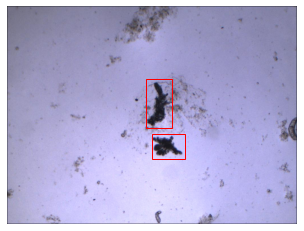

prediction time is 0.6051335334777832s


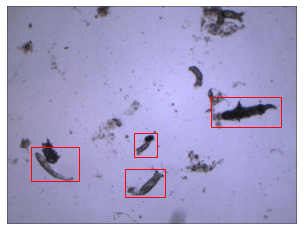

prediction time is 0.6217403411865234s


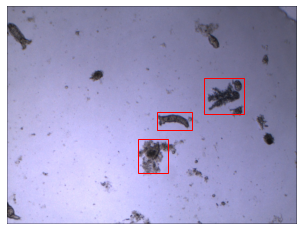

prediction time is 0.619295597076416s


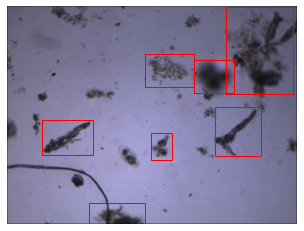

prediction time is 0.6361894607543945s


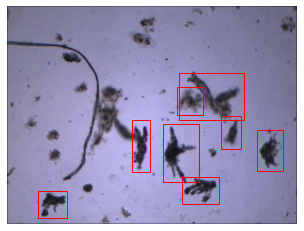

prediction time is 0.6446261405944824s


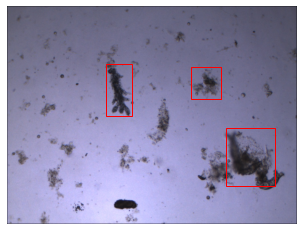

prediction time is 0.6258244514465332s


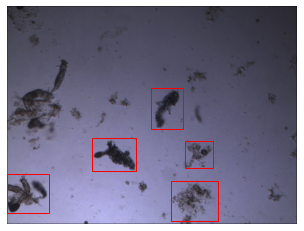

prediction time is 0.6281225681304932s


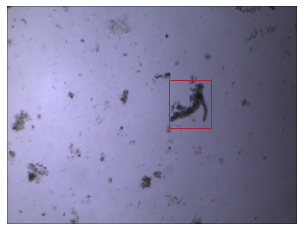

prediction time is 0.6178689002990723s


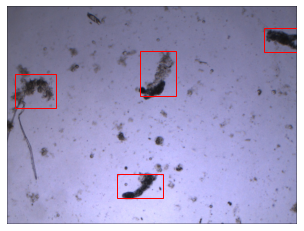

prediction time is 0.6244847774505615s


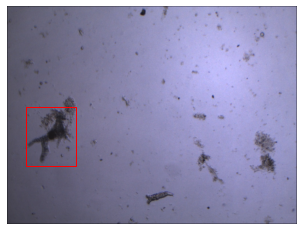

prediction time is 0.6147077083587646s


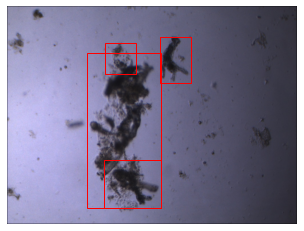

prediction time is 0.6235325336456299s


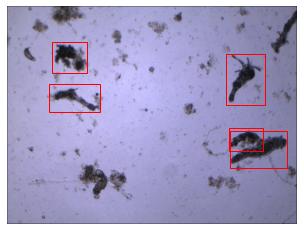

prediction time is 0.6289730072021484s


In [ ]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from PIL import Image
import time

def plot_predicted(image, model, cfg):
  image = np.asanyarray(image)
  scaled_image = mold_image(image, cfg)
  sample = expand_dims(image, 0)
  yhat = model.detect(sample, verbose=0)[0]
  pyplot.imshow(image)
  ax = pyplot.gca()
  pyplot.axis("off")
  for box in yhat['rois']:
    y1, x1, y2, x2 = box
    width, height = x2 - x1, y2 - y1
    rect = Rectangle((x1, y1), width, height, fill=False, color='red')
    ax.add_patch(rect)
  pyplot.savefig("image.jpg")
  pyplot.show()

images_dir = "testDataset/images"
for img in listdir(images_dir):
  start = time.time()
  img_path = images_dir + "/" + img
  image = Image.open(img_path)
  image = np.asanyarray(image)
  plot_predicted(image, model, cfg)
  end = time.time()
  predTime = end - start
  print("prediction time is " + str(predTime) + "s")